In [ ]:
# mount Drive to access data files

from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import pandas, numpy, random
import matplotlib.pyplot as plt


class MnistDataset(Dataset):
  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header=None)
    pass
  
  def __len__(self):
    return len(self.data_df)
  
  def __getitem__(self, index):
    # 이미지 목표(레이블)
    label = self.data_df.iloc[index,0]
    target = torch.zeros((10))
    target[label] = 1.0

    # 0-255의 이미지를 0-1로 정규화
    image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values)/255.0
    
    # 레이블, 이미지 데이터 텐서, 목표 텐서 반환
    return label, image_values, target

  def plot_image(self, index):
    img = self.data_df.iloc[index,1:].values.reshape(28,28)
    plt.title("label = "+str(self.data_df.iloc[index,0]))
    plt.imshow(img, interpolation = 'none', cmap = 'Blues')
    pass

  pass


# load data
mnist_dataset = MnistDataset('/content/mount/MyDrive/Colab Notebooks/2022/여름방학/GAN첫걸음/myo_gan/mnist_data/mnist_train.csv')

# check data contains images
# mnist_dataset.plot_image(17)

ModuleNotFoundError: ignored

In [ ]:
# 판별기 만들기

class Discriminator(nn.Module):
  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(784,200),
        nn.LeakyReLU(0.02),
        nn.LayerNorm(200),
        nn.Linear(200,1),
        nn.Sigmoid()
    )

    # 손실함수 설정
    self.loss_function = nn.BCELoss()

    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass


  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, inputs, targets):
    # 신경망 출력 계산
    outputs = self.forward(inputs)

    # 손실 계산
    loss = self.loss_function(outputs, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass

    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass
    
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim = (0, 1.0), figsize = (16,8), alpha = 0.1, marker = '.', grid = True, yticks = (0,0.25,0.5))
    pass

# 판별기 테스트하기

def generate_random(size):
  random_data = torch.rand(size)
  return random_data

In [ ]:
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

In [ ]:
# %%time

# D = Discriminator()

# for label, image_data_tensor, target_tensor in mnist_dataset:
#   # 실제 데이터
#   D.train(image_data_tensor, torch.FloatTensor([1.0]))
#   # 랜덤으로 생성된 데이터
#   D.train(generate_random(784),torch.FloatTensor([0.0]))
#   pass

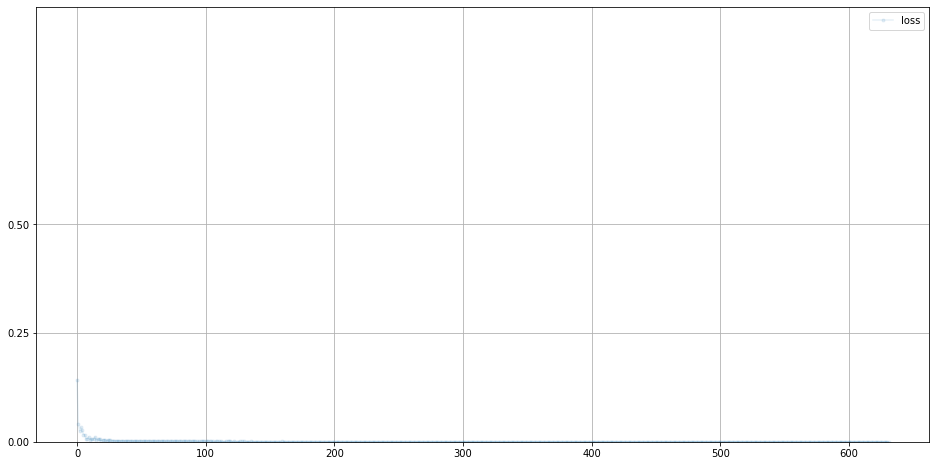

In [ ]:
D.plot_progress()

In [ ]:
# manually run discriminator to check it can tell real data from fake

# for i in range(4):
#   image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
#   print(D.forward(image_data_tensor).item())
#   pass

# for i in range(4):
#   print(D.forward(generate_random(784)).item())
#   pass

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    # 파이토치 부모 클래스 초기화
    super().__init__()

    # 신경망 레이어 정의
    self.model = nn.Sequential(
        nn.Linear(100,200),
        nn.LeakyReLU(0.02),
        nn.LayerNorm(200),
        nn.Linear(200,784),
        nn.Sigmoid()
    )

    # SGD 옵티마이저 설정
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 진행 측정을 위한 변수 초기화
    self.counter = 0;
    self.progress = []

    pass


  def forward(self, inputs):
    # 모델 실행
    return self.model(inputs)

  def train(self, D, inputs, targets):
    # 신경망 출력 계산
    g_output = self.forward(inputs)

    # 판별기로 전달
    d_output = D.forward(g_output)

    # 오차 계산
    loss = D.loss_function(d_output, targets)

    # 카운터를 증가시키고 10회마다 오차 저장
    self.counter += 1;
    if(self.counter%10 == 0):
      self.progress.append(loss.item())
      pass

    # 기울기를 초기화하고 역전파 후 가중치 갱신
    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass
    
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim = (0, 1.0), figsize = (16,8), alpha = 0.1, marker = '.', grid = True, yticks = (0,0.25,0.5))
    pass

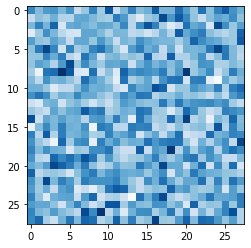

In [ ]:
# check the generator ouput is of the right type and shape
G = Generator()
output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28,28)
plt.imshow(img, interpolation = 'none', cmap = 'Blues')

In [ ]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

epochs = 4

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for label, image_data_tensor, target_tensor in mnist_dataset:
    # train discriminator on true
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
    
    # train generator
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))

    pass
    
  pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 30min 18s, sys: 26 s, total: 30min 44s
Wall time: 30min 45s


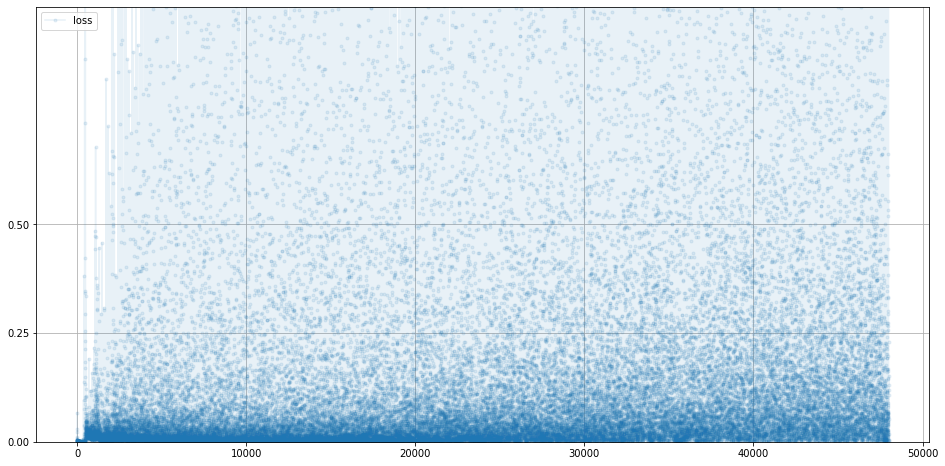

In [ ]:
D.plot_progress()

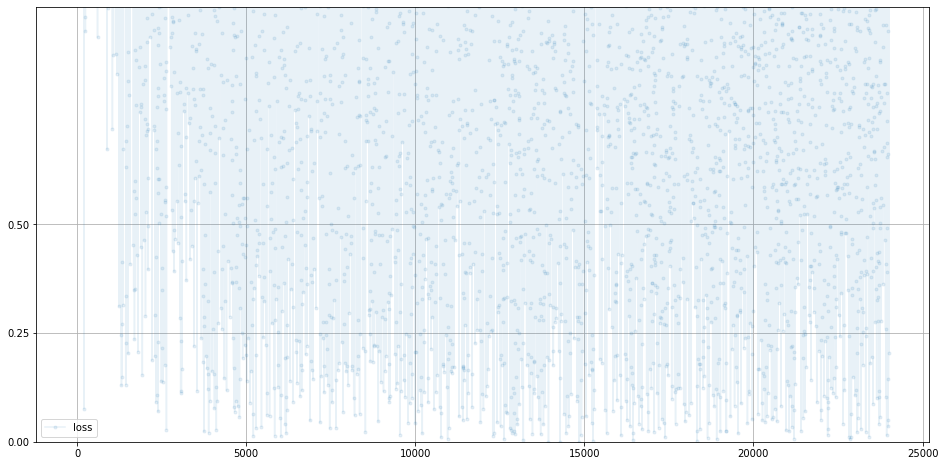

In [ ]:
G.plot_progress()

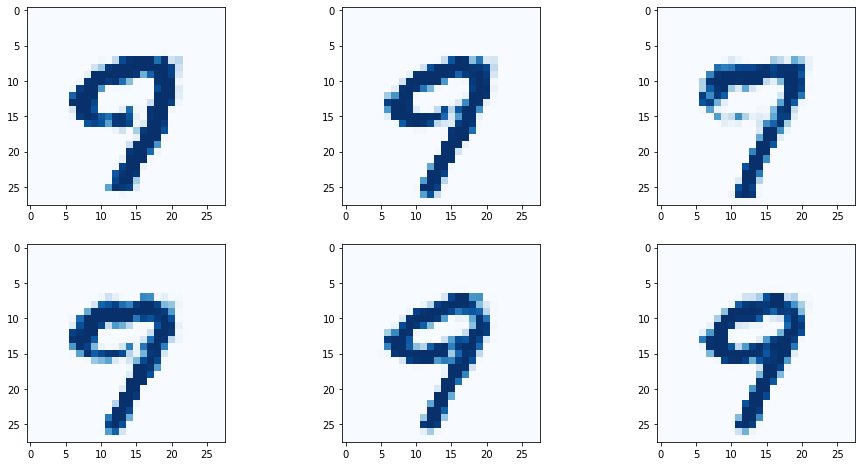

In [ ]:
# 2행 3열로 생성된 이미지 출력
f, axarr = plt.subplots(2,3,figsize=(16,8))

for i in range(2):
  for j in range(3):
    output = G.forward(generate_random(100))
    img = output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation = 'none', cmap = 'Blues')
    pass
  pass

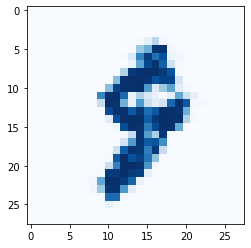

In [ ]:
seed1 = generate_random_seed(100)
out1 = G.forward(seed1)
img1 = out1.detach().numpy().reshape(28,28)
plt.imshow(img1, interpolation = 'none', cmap = 'Blues')

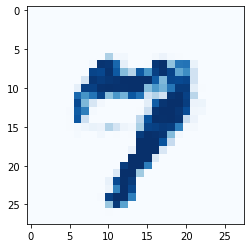

In [ ]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.detach().numpy().reshape(28,28)
plt.imshow(img1, interpolation = 'none', cmap = 'Blues')

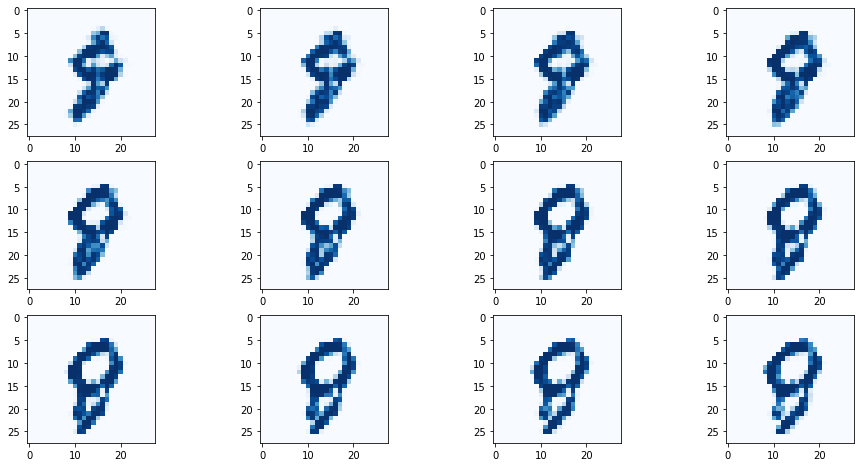

In [ ]:
count = 0

# 2행 3열로 생성된 이미지 출력
f, axarr = plt.subplots(3,4,figsize=(16,8))
for i in range(3):
  for j in range(4):
    seed = seed1 + (seed2-seed1)/11 * count
    output = G.forward(seed)
    img = output.detach().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation = 'none', cmap = 'Blues')
    count = count + 1
    pass
  pass

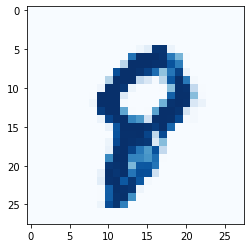

In [ ]:
seed3 = seed1 + seed2
out3 = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28,28)
plt.imshow(img3, interpolation = 'none', cmap = 'Blues')

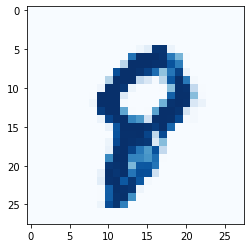

In [ ]:
seed4 = seed1 - seed2
out4 = G.forward(seed4)
img4 = out3.detach().numpy().reshape(28,28)
plt.imshow(img3, interpolation = 'none', cmap = 'Blues')